# Double-Bracket Iteration Strategy: Pauli-Z products

In this example, we demonstrate the usage of the DBI strategy: Pauli-Z products, where the diagonal operator is chosen as the optimal product of Pauli-Z operators.

In [111]:
from copy import copy, deepcopy

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from qibo import hamiltonians, set_backend
from qibo.hamiltonians import Hamiltonian, SymbolicHamiltonian
from qibo.models.dbi.double_bracket import DoubleBracketGeneratorType, DoubleBracketIteration
from qibo.models.dbi.additional_double_bracket_functions import *
from qibo.symbols import I, X, Z

## The initial setup

As an example, we consider the Transverse Field Ising Model (TFIM):
$$ H_{\rm TFIM} = - \sum_{i=1}^{N}\bigl( Z_i Z_{i+1} + h X_i \bigr),$$
which is already implemented in `Qibo`. For this tutorial we set $N=5$ and $h=3$.

In [112]:
# set the qibo backend (we suggest qibojit if N >= 20)
# alternatives: tensorflow (not optimized), numpy (when CPU not supported by jit)
set_backend("qibojit", "numba")

# hamiltonian parameters
nqubits = 5
h = 3

# define the hamiltonian
H_TFIM = hamiltonians.TFIM(nqubits=nqubits, h=h)

# initialize class
# Note: use deepcopy to prevent h being edited
dbi = DoubleBracketIteration(deepcopy(H_TFIM),mode=DoubleBracketGeneratorType.single_commutator)
print("Initial off diagonal norm", dbi.off_diagonal_norm)

[Qibo 0.2.3|INFO|2023-12-20 17:31:22]: Using qibojit (numba) backend on /CPU:0


Initial off diagonal norm 37.94733192202055


## Local Z operators
Denoted as local Z operators, the diagonal operators used for this strategy are tensor products of pauli Z and identity.

In [113]:
generate_local_Z = generate_Z_operators(nqubits)
Z_ops = generate_local_Z["Z_operators"]
Z_names = generate_local_Z["Z_words"]

[Qibo 0.2.3|WARNING|2023-12-20 17:31:22]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.3|WARNING|2023-12-20 17:31:22]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.3|WARNING|2023-12-20 17:31:22]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.3|WARNING|2023-12-20 17:31:22]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.3|WARNING|2023-12-20 17:31:22]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.3|WARNING|2023-12-20 17:31:22]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.3|WARNING|2023-12-20 17:31:22]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.3|WARNING|2023-12-20 17:31:22]: Calculating the dens

## Iteration from list

In [114]:
NSTEPS = 10
Z_optimal = []
off_diagonal_norm_history = [dbi.off_diagonal_norm]
steps = [0]
for _ in range(NSTEPS):
    idx, step = select_best_dbr_generator_and_run(dbi, Z_ops, compare_canonical=False)
    off_diagonal_norm_history.append(dbi.off_diagonal_norm)
    steps.append(steps[-1]+step)
    if idx == len(Z_ops):
        Z_optimal.append("canonical")
    else:
        Z_optimal.append(Z_names[idx])
    print(f"New optimized step at iteration {_+1}/{NSTEPS}: {step} with operator {Z_optimal[-1]}")

New optimized step at iteration 1/10: 0.226541694813849 with operator ZZZZI
New optimized step at iteration 2/10: 0.04365219052800224 with operator ZIIIZ
New optimized step at iteration 3/10: 0.0004223910173936202 with operator ZIIIZ
New optimized step at iteration 4/10: 0.0005286811447081021 with operator ZIIIZ
New optimized step at iteration 5/10: 0.005143071387459883 with operator ZIIIZ
New optimized step at iteration 6/10: 0.035695046259435294 with operator IIIZZ
New optimized step at iteration 7/10: 0.051138876252057375 with operator IZIIZ
New optimized step at iteration 8/10: 0.058915541216558114 with operator IIIZZ
New optimized step at iteration 9/10: 0.06227076215089642 with operator IIZII
New optimized step at iteration 10/10: 0.004415480749114426 with operator ZIIIZ


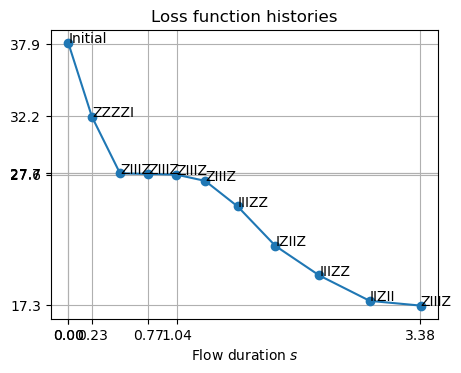

In [115]:
plot_histories(off_diagonal_norm_history, steps, Z_optimal)

It is worth noting that due to the nature of `hyperopt`, the iterations may be unstable and multiple runs may be required for the optimal result (alternatively, we can perform a grid search on the optimal step). Hence, it is sometimes needed to adjust its parameters including the following:

- step_min
- step_max
- max_evals

## Compare with canonical

In [116]:
# set the qibo backend (we suggest qibojit if N >= 20)
# alternatives: tensorflow (not optimized), numpy (when CPU not supported by jit)
set_backend("qibojit", "numba")


# initialize class|
# Note: use deepcopy to prevent h being edited
dbi_canonical = DoubleBracketIteration(deepcopy(H_TFIM),mode=DoubleBracketGeneratorType.canonical)
print("Initial off diagonal norm", dbi_canonical.off_diagonal_norm)

[Qibo 0.2.3|INFO|2023-12-20 17:31:23]: Using qibojit (numba) backend on /CPU:0


Initial off diagonal norm 37.94733192202055


In [117]:
off_diagonal_norm_history_canonical = [dbi_canonical.off_diagonal_norm]
steps_canonical = [0]
steps_canonical_plot = [0]
for s in range(NSTEPS):
    step = dbi_canonical.hyperopt_step(
        step_min = 1e-5,
        step_max = 1,
        space = hp.uniform,
        optimizer = tpe,
        max_evals = 100,
    )
    print(f"New optimized step at iteration {s+1}/{NSTEPS}: {step}")
    dbi_canonical(step=step)
    off_diagonal_norm_history_canonical.append(dbi_canonical.off_diagonal_norm)
    steps_canonical.append(step)
    steps_canonical_plot.append(steps_canonical_plot[-1]+step)

New optimized step at iteration 1/10: 0.7146460310874032
New optimized step at iteration 2/10: 0.01295934582879973
New optimized step at iteration 3/10: 0.0073423008284427375
New optimized step at iteration 4/10: 0.005757100401123474
New optimized step at iteration 5/10: 0.00725004121094582
New optimized step at iteration 6/10: 0.00878215971833188
New optimized step at iteration 7/10: 0.008138545510328506
New optimized step at iteration 8/10: 0.008905425886364926
New optimized step at iteration 9/10: 0.0071714932971553135
New optimized step at iteration 10/10: 0.0050508011630583174


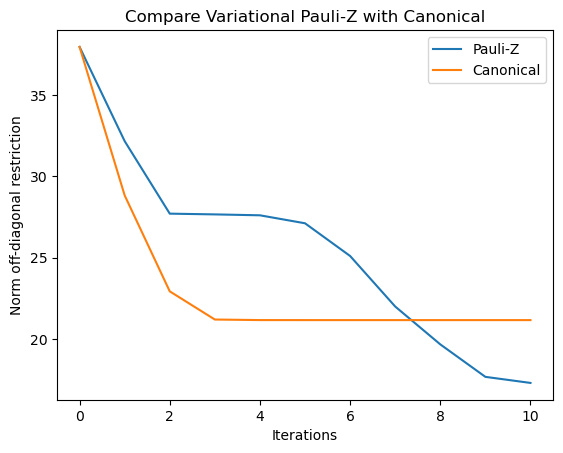

In [118]:
plt.figure()
# plt.plot(steps, off_diagonal_norm_history, label="Pauli-Z")
# plt.plot(steps_canonical, off_diagonal_norm_history_canonical, label="Canonical")
plt.plot(off_diagonal_norm_history, label="Pauli-Z")
plt.plot(off_diagonal_norm_history_canonical, label="Canonical")
plt.xlabel("Iterations")
plt.ylabel("Norm off-diagonal restriction")
plt.title("Compare Variational Pauli-Z with Canonical")
plt.legend()

Here we see that variationally chosen diagonal operators are less likely to converge to a local minimum compared to the GWW flow. 

## Mixed strategy

Since the canonical double bracket iteration performs better at the initial steps, we attempt to combine the two strategies: iterate a few steps using the canonical bracket before switching to the variational Z-operators.

In [119]:
dbi_mixed= DoubleBracketIteration(deepcopy(H_TFIM),mode=DoubleBracketGeneratorType.canonical)
print("Initial off diagonal norm", dbi_mixed.off_diagonal_norm)

Initial off diagonal norm 37.94733192202055


In [120]:
print(steps_canonical)
print(off_diagonal_norm_history_canonical)

[0, 0.7146460310874032, 0.01295934582879973, 0.0073423008284427375, 0.005757100401123474, 0.00725004121094582, 0.00878215971833188, 0.008138545510328506, 0.008905425886364926, 0.0071714932971553135, 0.0050508011630583174]
[37.94733192202055, 28.819909345949704, 22.92044340981513, 21.188224428205743, 21.154011569814752, 21.152981183370528, 21.15289615375783, 21.15289397912285, 21.15289385280897, 21.152893836911957, 21.152893836305644]


In [121]:
# Run the initial iterations using canonical iterations
off_diagonal_norm_history_mixed = [dbi_mixed.off_diagonal_norm]
steps_mixed = [0]
cannonical_NSTEPS = 2
for i in range(cannonical_NSTEPS):
    step = steps_canonical[i+1]
    dbi_mixed(step=step)
    off_diagonal_norm_history_mixed.append(dbi_mixed.off_diagonal_norm)
    steps_mixed.append(step)
    
print("After 2 steps, off diagonal norm:", dbi_mixed.off_diagonal_norm)
print("By comparison, the Pauli-Z:", off_diagonal_norm_history[2])

After 2 steps, off diagonal norm: 22.92044340981513
By comparison, the Pauli-Z: 27.697127814319394


In [122]:
# Continue the remaining steps with Pauli-Z operators
Z_optimal_mixed = ["Cannonical" for _ in range(cannonical_NSTEPS)]
remaining_NSTEPS = NSTEPS - cannonical_NSTEPS
dbi_mixed.mode = DoubleBracketGeneratorType.single_commutator
for _ in range(remaining_NSTEPS):
    idx, step = select_best_dbr_generator_and_run(dbi_mixed, Z_ops, compare_canonical=True)
    off_diagonal_norm_history_mixed.append(dbi_mixed.off_diagonal_norm)
    steps_mixed.append(step)
    if idx == len(Z_ops):
        Z_optimal_mixed.append("canonical")
    else:
        Z_optimal_mixed.append(Z_names[idx])
    print(f"New optimized step at iteration {_+1}/{remaining_NSTEPS}: {step} with operator {Z_optimal_mixed[-1]}")

New optimized step at iteration 1/8: 0.05941564262362324 with operator ZZIZZ
New optimized step at iteration 2/8: 0.03940145130227511 with operator ZIZIZ
New optimized step at iteration 3/8: 0.0011280629619659756 with operator canonical
New optimized step at iteration 4/8: 0.0006687287367940978 with operator canonical
New optimized step at iteration 5/8: 7.009154476669683e-05 with operator canonical
New optimized step at iteration 6/8: 0.0006524905648483872 with operator canonical
New optimized step at iteration 7/8: 0.0004846714536669654 with operator canonical
New optimized step at iteration 8/8: 0.00042762745962869885 with operator canonical


In [123]:
print(off_diagonal_norm_history_mixed)
print(steps_mixed)
print(Z_optimal_mixed)

[37.94733192202055, 28.819909345949704, 22.92044340981513, 21.34720527797985, 21.054031744647673, 20.213777401246823, 19.785419985540294, 19.744094238325083, 19.37058316672788, 19.1198463086939, 18.91557430830763]
[0, 0.7146460310874032, 0.01295934582879973, 0.05941564262362324, 0.03940145130227511, 0.0011280629619659756, 0.0006687287367940978, 7.009154476669683e-05, 0.0006524905648483872, 0.0004846714536669654, 0.00042762745962869885]
['Cannonical', 'Cannonical', 'ZZIZZ', 'ZIZIZ', 'canonical', 'canonical', 'canonical', 'canonical', 'canonical', 'canonical']


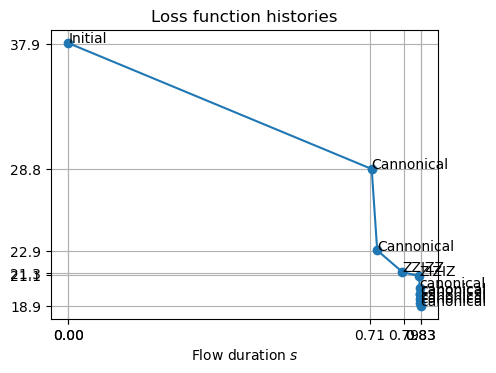

In [126]:
plot_histories(off_diagonal_norm_history_mixed, steps_mixed, Z_optimal_mixed)

We see that the mixed strategy does not necessarily give a better result, this could also be a result of the unstability of hyperopt.